In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

# IMPORT DATA
data = data = pd.read_csv(r'data/train.csv')
x = data.drop(['label'], axis=1)
y = np.asarray(data.label)

# PROCESS X A BIT ...
x = np.asarray(x).astype(np.float32)
x = x.reshape(x.shape[0], 1, 28, 28)
x = x/255

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, shuffle=True, random_state=10)

# DECREASE LEARNING RATE EACH EPOCH
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)


## Experiment 1
First question, how many pairs of convolution-subsampling should we use? For example, our network could have 1, 2, or 3.
I'm not doing four pairs since the image will be reduced too small before then. The input image is 28x28. After one pair, it's 14x14. After two, it's 7x7. After three it's 4x4 (or 3x3 if we don't use padding='same'). It doesn't make sense to do a fourth convolution.

In [2]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS WITH USAGE OF GPU
nets = 3
model = [0] *nets
epochs = 15

with tf.device('/device:GPU:0'):
    for j in range(3):
        model[j] = tf.keras.Sequential()
        model[j].add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
                data_format='channels_first'))
        model[j].add(MaxPool2D())
        if j>0:
            model[j].add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
            model[j].add(MaxPool2D())
        if j>1:
            model[j].add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
            model[j].add(MaxPool2D(padding='same'))
            
        model[j].add(Flatten())
        model[j].add(Dense(256, activation='relu'))
        model[j].add(Dense(10, activation='softmax'))
        model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # TRAIN NETWORKS
    history = [0] * nets
    names = ["(C-P)x1","(C-P)x2","(C-P)x3"]

    for j in range(nets):
        history[j] = model[j].fit(x_train, y_train, batch_size=200, epochs = epochs, 
            validation_data = (x_val, y_val), verbose=0)
        print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN (C-P)x1: Epochs=15, Train accuracy=0.99985, Validation accuracy=0.99583
CNN (C-P)x2: Epochs=15, Train accuracy=0.99885, Validation accuracy=0.99450
CNN (C-P)x3: Epochs=15, Train accuracy=0.99793, Validation accuracy=0.99450


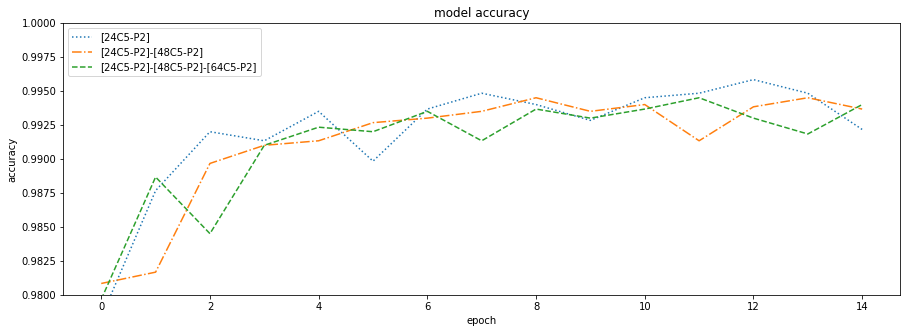

In [3]:
# PLOT LOSSES
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']
names = ['[24C5-P2]', '[24C5-P2]-[48C5-P2]', '[24C5-P2]-[48C5-P2]-[64C5-P2]']
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## Summary
It seems that two pairs have similar performance like three pairs. However the imrovement is not worth the computional cost.

## Experiment 2
In the previous experiement, we decided that two pairs is sufficient. How many feature maps should we include? For example, we could do

 * 784 - [8C5-P2] - [16C5-P2] - 256 - 10
 * 784 - [16C5-P2] - [32C5-P2] - 256 - 10
 * 784 - [32C5-P2] - [64C5-P2] - 256 - 10
 * 784 - [48C5-P2] - [96C5-P2] - 256 - 10
 * 784 - [64C5-P2] - [128C5-P2] - 256 - 10

In [15]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 6
model = [0] *nets
names = ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"]

with tf.device('/device:GPU:0'):
    for j in range(6):
        model[j] = tf.keras.Sequential()
        model[j].add(Conv2D(j*8+8,kernel_size=5,activation='relu',padding='same',data_format='channels_first'))
        model[j].add(MaxPool2D())
        
        model[j].add(Conv2D(j*16+16,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D())
        
        model[j].add(Flatten())
        model[j].add(Dense(256, activation='relu'))
        model[j].add(Dense(10, activation='softmax'))
        model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    # TRAIN NETWORKS
    history = [0] * nets
    
    for j in range(nets):
        history[j] = model[j].fit(x_train, y_train, batch_size=200, epochs = epochs, 
            validation_data = (x_val, y_val), callbacks=[annealer], verbose=0)
        print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 8 maps: Epochs=15, Train accuracy=0.99731, Validation accuracy=0.99450
CNN 16 maps: Epochs=15, Train accuracy=0.99896, Validation accuracy=0.99433
CNN 24 maps: Epochs=15, Train accuracy=0.99933, Validation accuracy=0.99467
CNN 32 maps: Epochs=15, Train accuracy=0.99969, Validation accuracy=0.99567
CNN 48 maps: Epochs=15, Train accuracy=0.99987, Validation accuracy=0.99483
CNN 64 maps: Epochs=15, Train accuracy=0.99981, Validation accuracy=0.99600


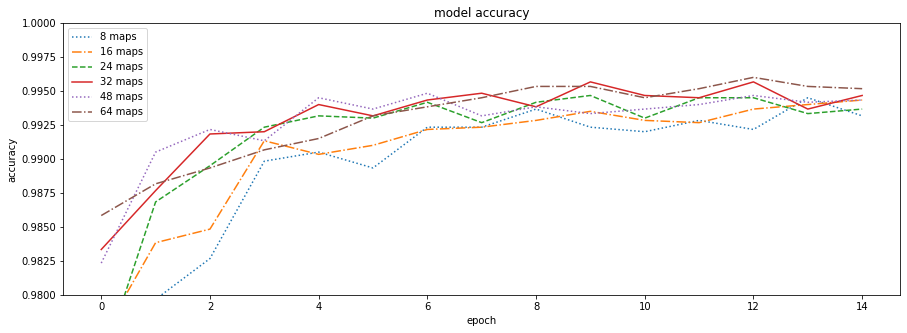

In [16]:
# PLOT ACCURACIES
names = ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"]
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## Summary
32 maps and 64 maps have very similar performancies, 784 - [64C5-P2] - [128C5-P2] - 256 - 10 is not worth additional computional costs

## Experiment 3
How many dense units should we use? For example we could use
  *  784 - [32C5-P2] - [64C5-P2] - 0 - 10
  *  784 - [32C5-P2] - [64C5-P2] - 32 - 10
  *  784 - [32C5-P2] - [64C5-P2] - 64 - 10
  *  784 - [32C5-P2] - [64C5-P2] - 128 -10
  *  784 - [32C5-P2] - [64C5-P2] - 256 - 10
  *  784 - [32C5-P2] - [64C5-P2] - 512 -10
  *  784 - [32C5-P2] - [64C5-P2] - 1024 - 10
  *  784 - [32C5-P2] - [64C5-P2] - 2048 - 10

In [20]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets
names = ["0N","32N","64N","128N","256N","512N","1024N","2048N"]

with tf.device('/device:GPU:0'):
    for j in range(8):
        model[j] = tf.keras.Sequential()
        model[j].add(Conv2D(32,kernel_size=5,activation='relu',padding='same',data_format='channels_first'))
        model[j].add(MaxPool2D())
        
        model[j].add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
        model[j].add(MaxPool2D())
        model[j].add(Flatten())
        
        if j>0:
            model[j].add(Dense(2**(j+4), activation='relu'))
        model[j].add(Dense(10, activation='softmax'))
        model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        
    # TRAIN NETWORKS
    history = [0] * nets

    for j in range(nets):
        history[j] = model[j].fit(x_train, y_train, batch_size=300, epochs = epochs, 
            validation_data = (x_val, y_val), callbacks=[annealer], verbose=0)
        print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 0N: Epochs=15, Train accuracy=0.99744, Validation accuracy=0.99317
CNN 32N: Epochs=15, Train accuracy=0.99726, Validation accuracy=0.99417
CNN 64N: Epochs=15, Train accuracy=0.99857, Validation accuracy=0.99417
CNN 128N: Epochs=15, Train accuracy=0.99859, Validation accuracy=0.99517
CNN 256N: Epochs=15, Train accuracy=0.99919, Validation accuracy=0.99500
CNN 512N: Epochs=15, Train accuracy=0.99939, Validation accuracy=0.99550
CNN 1024N: Epochs=15, Train accuracy=0.99993, Validation accuracy=0.99567
CNN 2048N: Epochs=15, Train accuracy=0.99972, Validation accuracy=0.99500


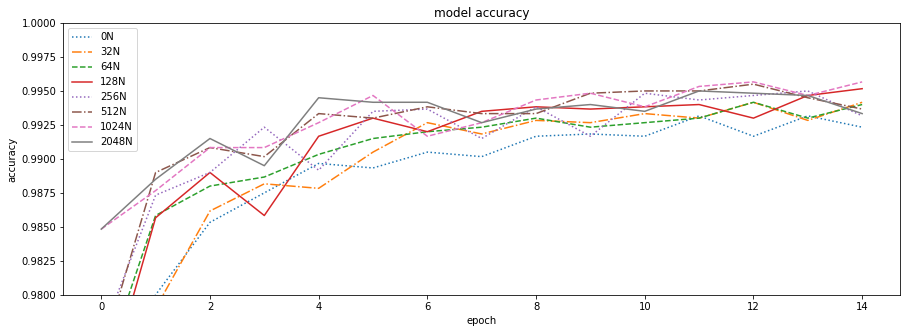

In [22]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## Summary
Best tradeoff between computional cost and performance has dense layer with size 128

## Experiment 4
Dropout will prevent our network from overfitting thus helping our network generalize better. How much dropout should we add after each layer? 
 * 0%, 10%, 20%, 30%, 40%, 50%, 60%, or 70%

In [25]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets
names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]

with tf.device('/device:GPU:0'):
    for j in range(8):
        model[j] = tf.keras.Sequential()
        model[j].add(Conv2D(32,kernel_size=5,activation='relu',data_format='channels_first'))
        model[j].add(MaxPool2D())
        model[j].add(Dropout(j*0.1))
        
        model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
        model[j].add(MaxPool2D())
        model[j].add(Dropout(j*0.1))
        
        model[j].add(Flatten())
        model[j].add(Dense(128, activation='relu'))
        model[j].add(Dropout(j*0.1))
        
        model[j].add(Dense(10, activation='softmax'))
        model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        
    # TRAIN NETWORKS
    history = [0] * nets

    for j in range(nets):
        history[j] = model[j].fit(x_train, y_train, batch_size=80, epochs = epochs, 
            validation_data = (x_val, y_val), callbacks=[annealer], verbose=0)
        print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))   

CNN D=0: Epochs=15, Train accuracy=0.99980, Validation accuracy=0.99600
CNN D=0.1: Epochs=15, Train accuracy=0.99857, Validation accuracy=0.99550
CNN D=0.2: Epochs=15, Train accuracy=0.99711, Validation accuracy=0.99450
CNN D=0.3: Epochs=15, Train accuracy=0.99600, Validation accuracy=0.99617
CNN D=0.4: Epochs=15, Train accuracy=0.99428, Validation accuracy=0.99617
CNN D=0.5: Epochs=15, Train accuracy=0.99085, Validation accuracy=0.99517
CNN D=0.6: Epochs=15, Train accuracy=0.98654, Validation accuracy=0.99283
CNN D=0.7: Epochs=15, Train accuracy=0.97765, Validation accuracy=0.99100


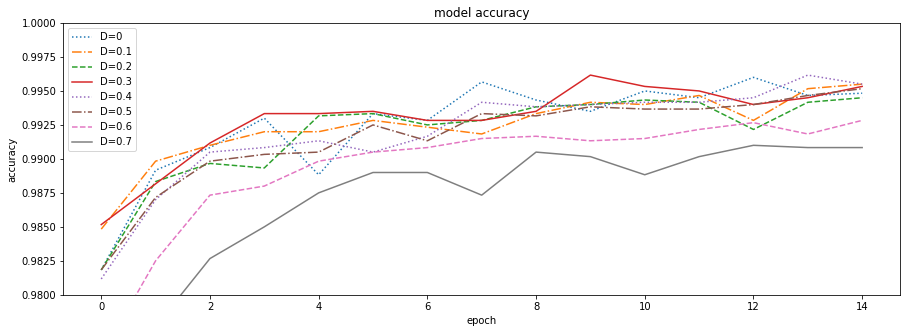

In [26]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## Summary
Dropout(0.3) seems like the best choice.

## Experiment 5 
#### Advanced features

Instead of using one convolution layer of size 5x5, you can mimic 5x5 by using two consecutive 3x3 layers and it will be more nonlinear. Instead of using a max pooling layer, you can subsample by using a convolution layer with strides=2 and it will be learnable. Lastly, does batch normalization help? And does data augmentation help? Let's test all four of these
 * replace '32C5' with '32C3-32C3'  
 * replace 'P2' with '32C5S2'
 * add batch normalization
 * add data augmentation

In [54]:
del(model)
model = [0] * 5
# 784 - [32C5-P2] - [64C5-P2] - 128 - 10
j = 0

model[j] = tf.keras.Sequential()
model[j].add(Conv2D(32,kernel_size=5,activation='relu',data_format='channels_first'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.3))

model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.3))

model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(Dropout(0.3))

model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 784 - [32C3-32C3-P2] - [64C3-64C3-P2] - 128 - 10
j = 1
model[j] = tf.keras.Sequential()
model[j].add(Conv2D(32,kernel_size=3,activation='relu',data_format='channels_first'))
model[j].add(Conv2D(32,kernel_size=3,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.3))

model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.3))

model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(Dropout(0.3))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 784 - [32C5-32C5S2] - [64C5-64C5S2] - 128 - 10
j = 2
model[j] = tf.keras.Sequential()
model[j].add(Conv2D(32,kernel_size=5,activation='relu',data_format='channels_first'))
model[j].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(Dropout(0.3))

model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
model[j].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(Dropout(0.3))

model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(Dropout(0.3))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10 + BN
j = 3
model[j] = tf.keras.Sequential()

model[j].add(Conv2D(32,kernel_size=3,activation='relu',data_format='channels_first'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())

model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())

model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10 + BN + DA
j = 4
model[j] = tf.keras.Sequential()

model[j].add(Conv2D(32,kernel_size=3,activation='relu',data_format='channels_first'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.3))

model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.3))

model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.3))
model[j].add(Dense(10, activation='softmax'))

model[j].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [56]:
# TRAIN NETWORKS 0,1,2,3,4
with tf.device('/device:GPU:0'):
    history = [0] * 5
    names = ["basic","32C3-32C3","32C5S2","both+BN","both+BN+DA"]

    for j in range(nets-3):
        history[j] = model[j].fit(x_train, y_train, batch_size=300, epochs = epochs, 
            validation_data = (x_val, y_val), callbacks=[annealer], verbose=0)
        print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN basic: Epochs=15, Train accuracy=0.99394, Validation accuracy=0.99550
CNN 32C3-32C3: Epochs=15, Train accuracy=0.99356, Validation accuracy=0.99383
CNN 32C5S2: Epochs=15, Train accuracy=0.99593, Validation accuracy=0.99467
CNN both+BN: Epochs=15, Train accuracy=0.99961, Validation accuracy=0.99300
CNN both+BN+DA: Epochs=15, Train accuracy=0.99815, Validation accuracy=0.99617


IndexError: list index out of range

In [57]:
nets

8

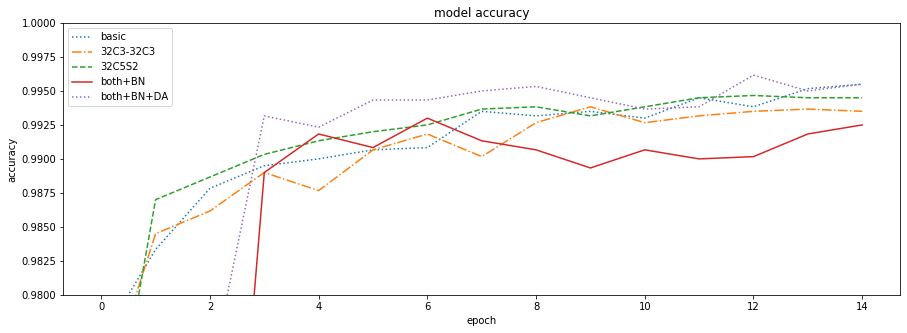

In [58]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets-3):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

## Summary
Final test showed that we had two options, basic which is 784 - [32C5-P2] - [64C5-P2] - 128 - 10 or 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10 + BN + DA. They have similar results but basic is far less computional expensive.